The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Changed DATE-OBS from '15/12/93' to '1993-12-15''. [astropy.wcs.wcs]
Changed DATE-OBS from '15/12/93' to '1993-12-15''. [astropy.wcs.wcs]


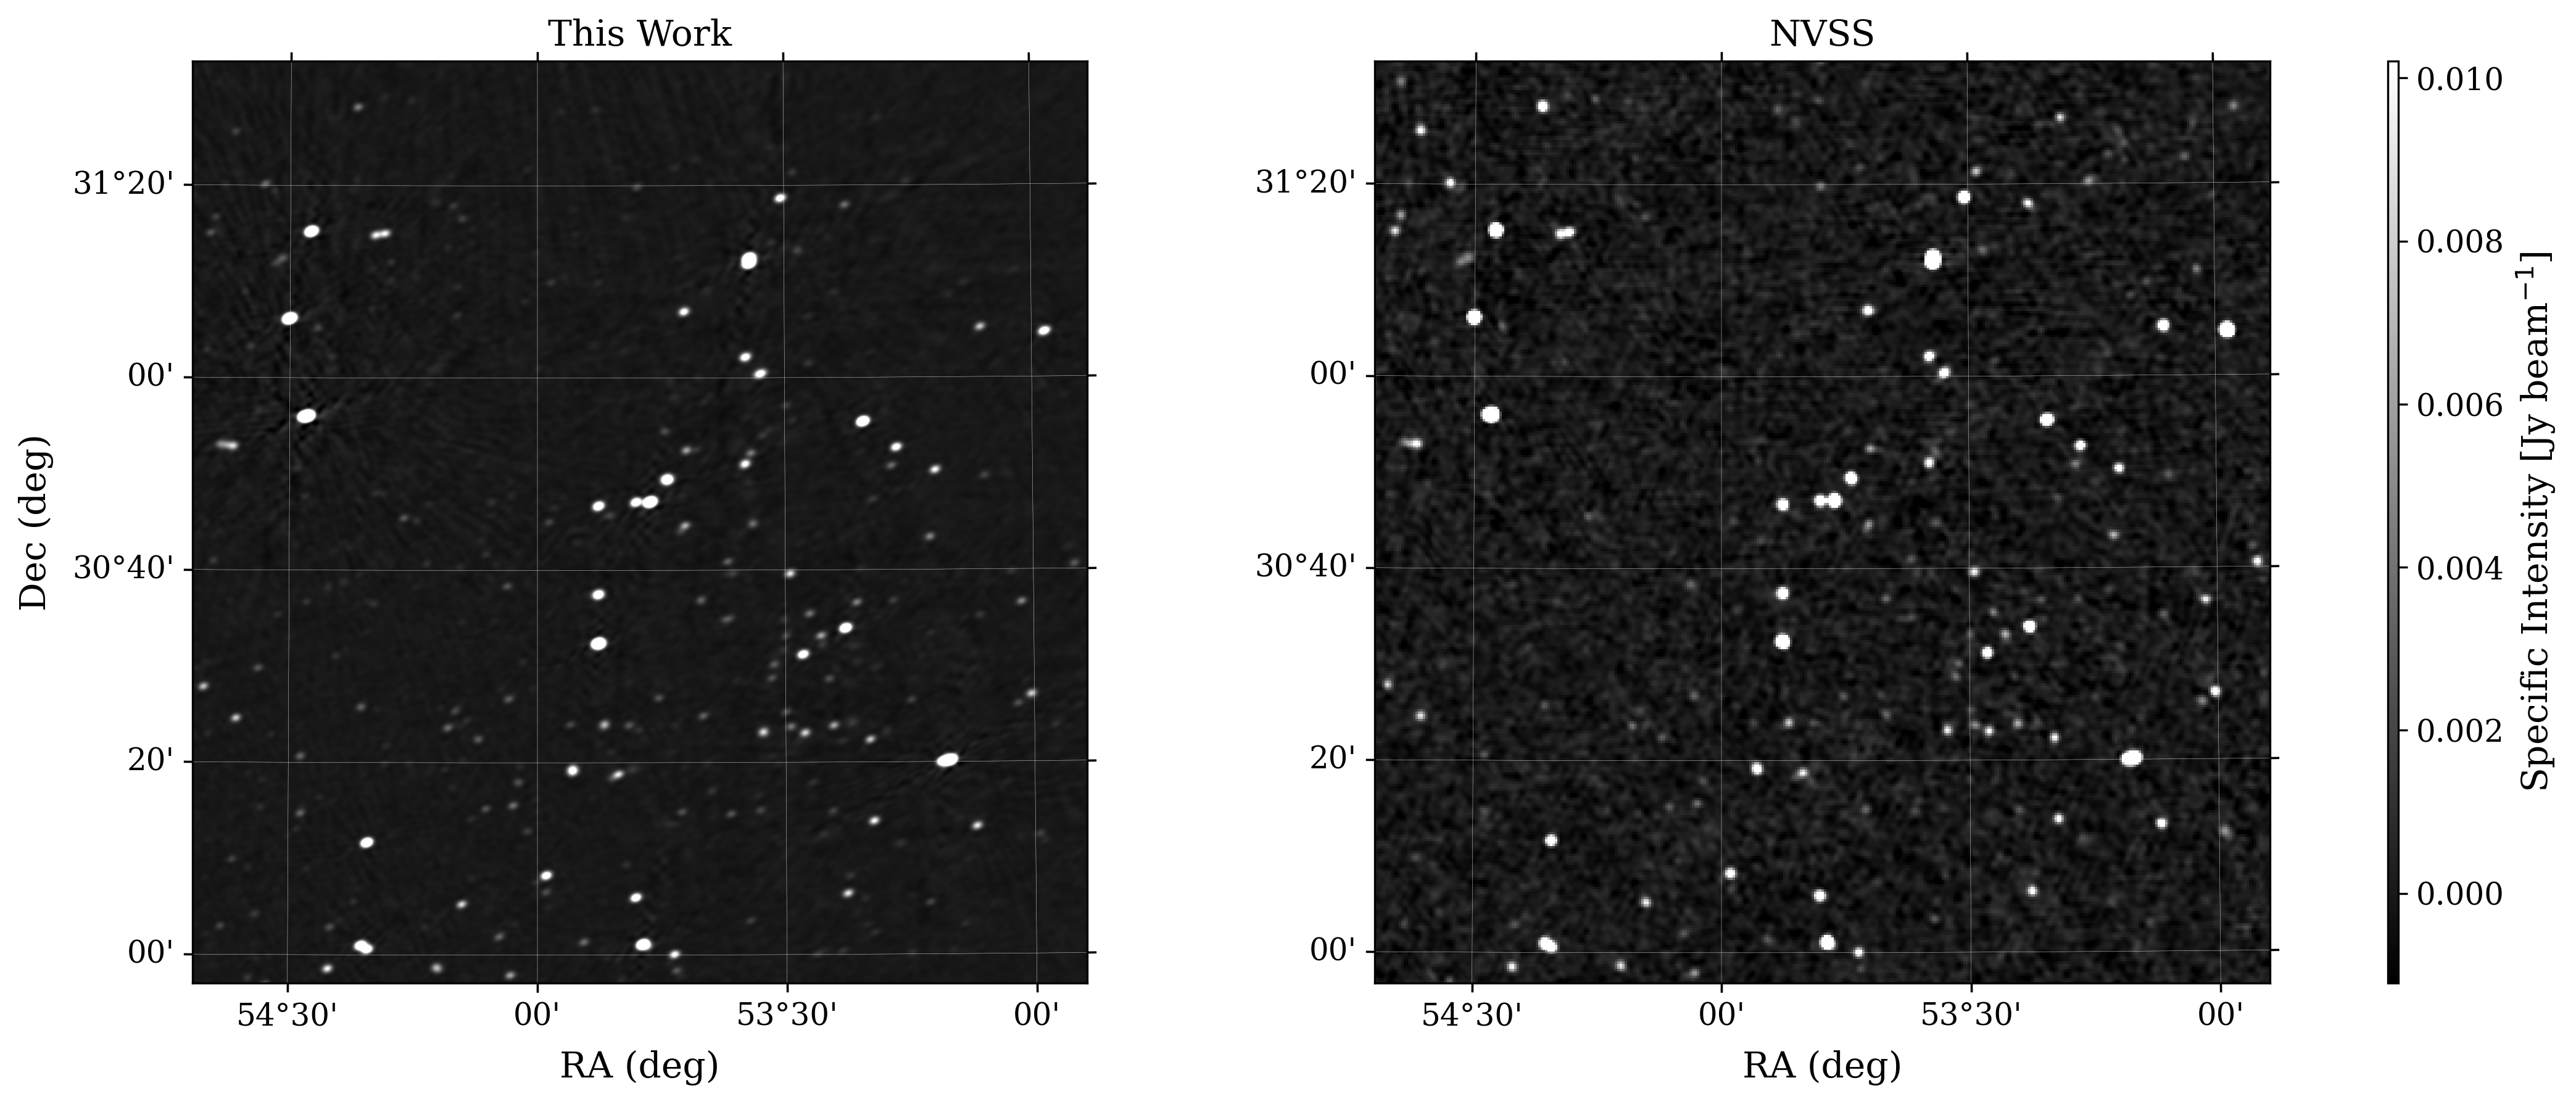

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from matplotlib.gridspec import GridSpec

# === Global Plot Styles ===
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# === Inputs ===
file1 = '../server/total/36ALL.fits'
file2 = '../NVSS/C0336P32_I.fits'
center = SkyCoord('03h35m12s', '30d44m53s', frame='icrs')
box_width = 1.8 * u.deg
box_height = 1.6 * u.deg

# === Optional: Set fixed image scale (vmin, vmax) or leave as None for automatic scaling ===
scale_limits = None  # Example: scale_limits = (0.001, 0.02)

def cutout_preserving_wcs(fitsfile, center, width, height, output_file):
    hdul = fits.open(fitsfile)
    header = hdul[0].header
    data = hdul[0].data
    wcs_full = WCS(header)
    wcs_sky = wcs_full.celestial

    half_width = width.to(u.deg).value / 2
    half_height = height.to(u.deg).value / 2
    ra1, ra2 = center.ra.deg - half_width, center.ra.deg + half_width
    dec1, dec2 = center.dec.deg - half_height, center.dec.deg + half_height
    corner1 = SkyCoord(ra1, dec1, unit='deg')
    corner2 = SkyCoord(ra2, dec2, unit='deg')

    x1, y1 = wcs_sky.world_to_pixel(corner1)
    x2, y2 = wcs_sky.world_to_pixel(corner2)
    x1, x2 = int(np.floor(min(x1, x2))), int(np.ceil(max(x1, x2)))
    y1, y2 = int(np.floor(min(y1, y2))), int(np.ceil(max(y1, y2)))

    cut_data = data[..., y1:y2, x1:x2]
    new_header = header.copy()
    new_header['CRPIX1'] -= x1
    new_header['CRPIX2'] -= y1
    new_header['NAXIS1'] = x2 - x1
    new_header['NAXIS2'] = y2 - y1

    for key in ['BMAJ', 'BMIN', 'BPA', 'RESTFRQ']:
        if key in header:
            new_header[key] = header[key]

    fits.writeto(output_file, cut_data, new_header, overwrite=True)
    return cut_data, WCS(new_header).celestial

# === Run cutouts ===
vla_data, vla_wcs = cutout_preserving_wcs(file1, center, box_width, box_height, '../paper1/figs/VLA_cutout.fits')
nvss_data, nvss_wcs = cutout_preserving_wcs(file2, center, box_width, box_height, '../paper1/figs/NVSS_cutout.fits')

# === Plotting ===
fig = plt.figure(figsize=(14, 6))  # Slightly wider for spacing
gs = GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.01])  # add space between images, keep colorbar close to NVSS

# Normalize across both images
vla_image = vla_data[0, 0] if vla_data.ndim == 4 else vla_data[0] if vla_data.ndim == 3 else vla_data
nvss_image = nvss_data[0, 0] if nvss_data.ndim == 4 else nvss_data[0] if nvss_data.ndim == 3 else nvss_data

# === Set scale automatically or from user-defined values ===
if scale_limits is None:
    vmin = min(np.nanpercentile(vla_image, 1), np.nanpercentile(nvss_image, 1))
    vmax = max(np.nanpercentile(vla_image, 99.4), np.nanpercentile(nvss_image, 99.6))
else:
    vmin, vmax = scale_limits

norm = Normalize(vmin=vmin, vmax=vmax)

# === VLA panel ===
ax1 = fig.add_subplot(gs[0, 0], projection=vla_wcs)
im1 = ax1.imshow(vla_image, origin='lower', cmap='gray', norm=norm)
ax1.set_title('This Work')
ax1.coords.grid(True, color='white', ls='solid', linewidth=0.1)
ax1.coords[0].set_axislabel('RA (deg)')
ax1.coords[1].set_axislabel('Dec (deg)')
ax1.coords[0].set_format_unit(u.deg)
ax1.coords[1].set_format_unit(u.deg)

# === NVSS panel ===
ax2 = fig.add_subplot(gs[0, 2], projection=nvss_wcs)
im2 = ax2.imshow(nvss_image, origin='lower', cmap='gray', norm=norm)
ax2.set_title('NVSS')
ax2.coords.grid(True, color='white', ls='solid', linewidth=0.1)
ax2.coords[0].set_axislabel('RA (deg)')
ax2.coords[1].set_axislabel('')  # remove duplicate Dec label
ax2.coords[0].set_format_unit(u.deg)
ax2.coords[1].set_format_unit(u.deg)
ax2.coords[1].set_ticklabel_position('l')  # left only

# === Shared colorbar ===
cax = fig.add_subplot(gs[0, 3])
sm = ScalarMappable(cmap='gray', norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cax)
cb.set_label("Specific Intensity [Jy beam$^{-1}$]", fontsize=14)
cb.ax.tick_params(labelsize=12)

# === Layout ===
fig.subplots_adjust(left=0.06, right=0.94, bottom=0.1, top=0.93, wspace=0.08)

# === Save and Show ===
plt.savefig("../paper1/figs/comparision.pdf", dpi=300, bbox_inches='tight')
plt.show()


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Changed DATE-OBS from '15/12/93' to '1993-12-15''. [astropy.wcs.wcs]
Changed DATE-OBS from '15/12/93' to '1993-12-15''. [astropy.wcs.wcs]
/var/folders/l1/vk05brrd5vgg5rxsglsqwbjh0000gn/T/ipykernel_55973/2979566609.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


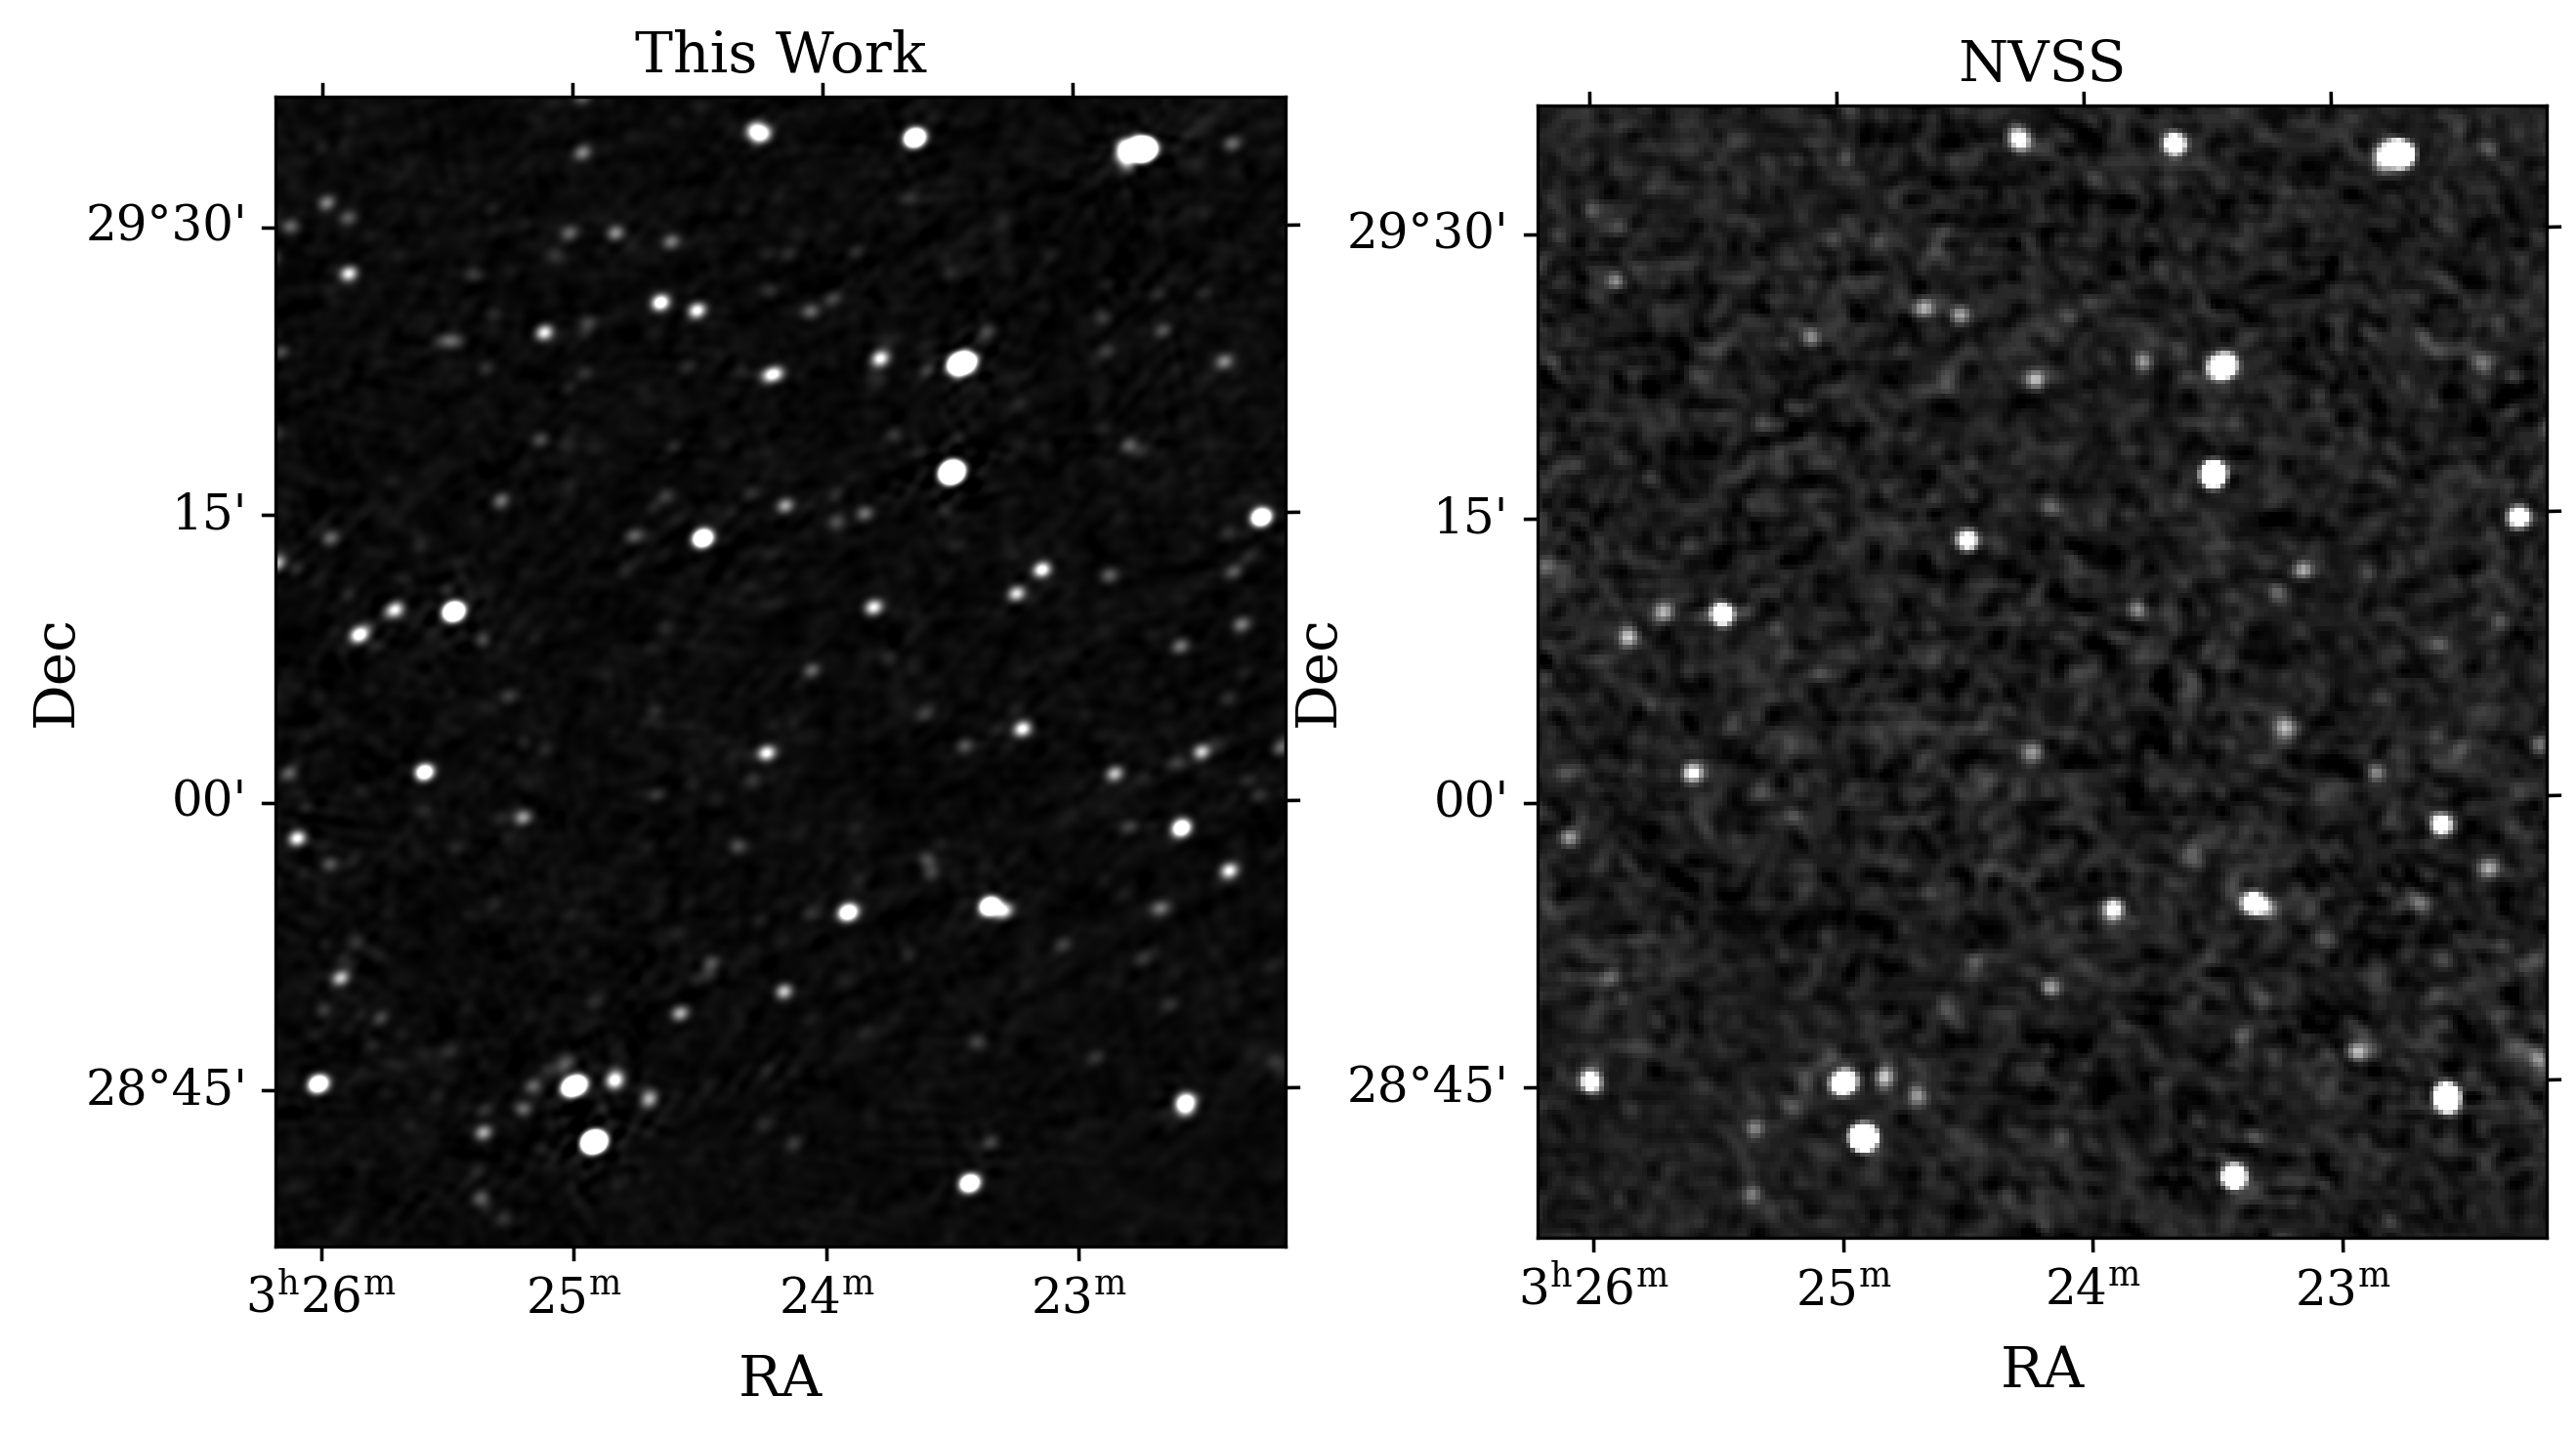

In [3]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from matplotlib.gridspec import GridSpec

# === Inputs ===
file1 = '../server/total/25ALL.fits'
file2 = '../NVSS/C0328P28_I.fits'
center = SkyCoord('03h24m11s', '29d06m48s', frame='icrs')
box_width = 1 * u.deg
box_height = 1 * u.deg

def cutout_preserving_wcs(fitsfile, center, width, height, output_file):
    hdul = fits.open(fitsfile)
    header = hdul[0].header
    data = hdul[0].data
    wcs_full = WCS(header)
    wcs_sky = wcs_full.celestial  # only RA/DEC part

    # Compute pixel bounds using celestial WCS
    half_width = width.to(u.deg).value / 2
    half_height = height.to(u.deg).value / 2

    ra1, ra2 = center.ra.deg - half_width, center.ra.deg + half_width
    dec1, dec2 = center.dec.deg - half_height, center.dec.deg + half_height

    corner1 = SkyCoord(ra1, dec1, unit='deg')
    corner2 = SkyCoord(ra2, dec2, unit='deg')

    x1, y1 = wcs_sky.world_to_pixel(corner1)
    x2, y2 = wcs_sky.world_to_pixel(corner2)

    # Round pixel bounds
    x1, x2 = int(np.floor(min(x1, x2))), int(np.ceil(max(x1, x2)))
    y1, y2 = int(np.floor(min(y1, y2))), int(np.ceil(max(y1, y2)))

    # Cut data (assume data shape is [..., y, x])
    cut_data = data[..., y1:y2, x1:x2]

    # Adjust CRPIX in header
    new_header = header.copy()
    new_header['CRPIX1'] -= x1
    new_header['CRPIX2'] -= y1
    new_header['NAXIS1'] = x2 - x1
    new_header['NAXIS2'] = y2 - y1

    # Preserve beam and freq info
    for key in ['BMAJ', 'BMIN', 'BPA', 'RESTFRQ']:
        if key in header:
            new_header[key] = header[key]

    # Save FITS
    fits.writeto(output_file, cut_data, new_header, overwrite=True)

    # Return 2D celestial WCS for plotting
    return cut_data, WCS(new_header).celestial

# === Run cutouts ===
vla_data, vla_wcs = cutout_preserving_wcs(file1, center, box_width, box_height, '../paper1/figs/VLA_cutout_new.fits')
nvss_data, nvss_wcs = cutout_preserving_wcs(file2, center, box_width, box_height, '../paper1/figs/NVSS_cutout_new.fits')

# === Plotting ===
fig = plt.figure(figsize=(10, 9))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.25)

for i, (data, wcs, title) in enumerate(zip(
    [vla_data, nvss_data], [vla_wcs, nvss_wcs], ['This Work', 'NVSS'])):

    # Reduce to 2D: handle 2D, 3D, 4D
    if data.ndim == 4:
        image = data[0, 0]
    elif data.ndim == 3:
        image = data[0]
    else:
        image = data

    ax = fig.add_subplot(gs[0, i], projection=wcs)
    vmin, vmax = np.nanpercentile(image, [1, 99.5])
    ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    ax.coords.grid(True, color='white', ls='dashed', linewidth=0.001)
    ax.set_title(title)
    ax.coords[0].set_axislabel('RA')
    ax.coords[1].set_axislabel('Dec', minpad=0.5)

plt.savefig("../paper1/figs/comparision.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



/var/folders/l1/vk05brrd5vgg5rxsglsqwbjh0000gn/T/ipykernel_55973/1149316800.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nvss_df = pd.read_csv(nvss_catalog, comment='#', delim_whitespace=True, names=col_names)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


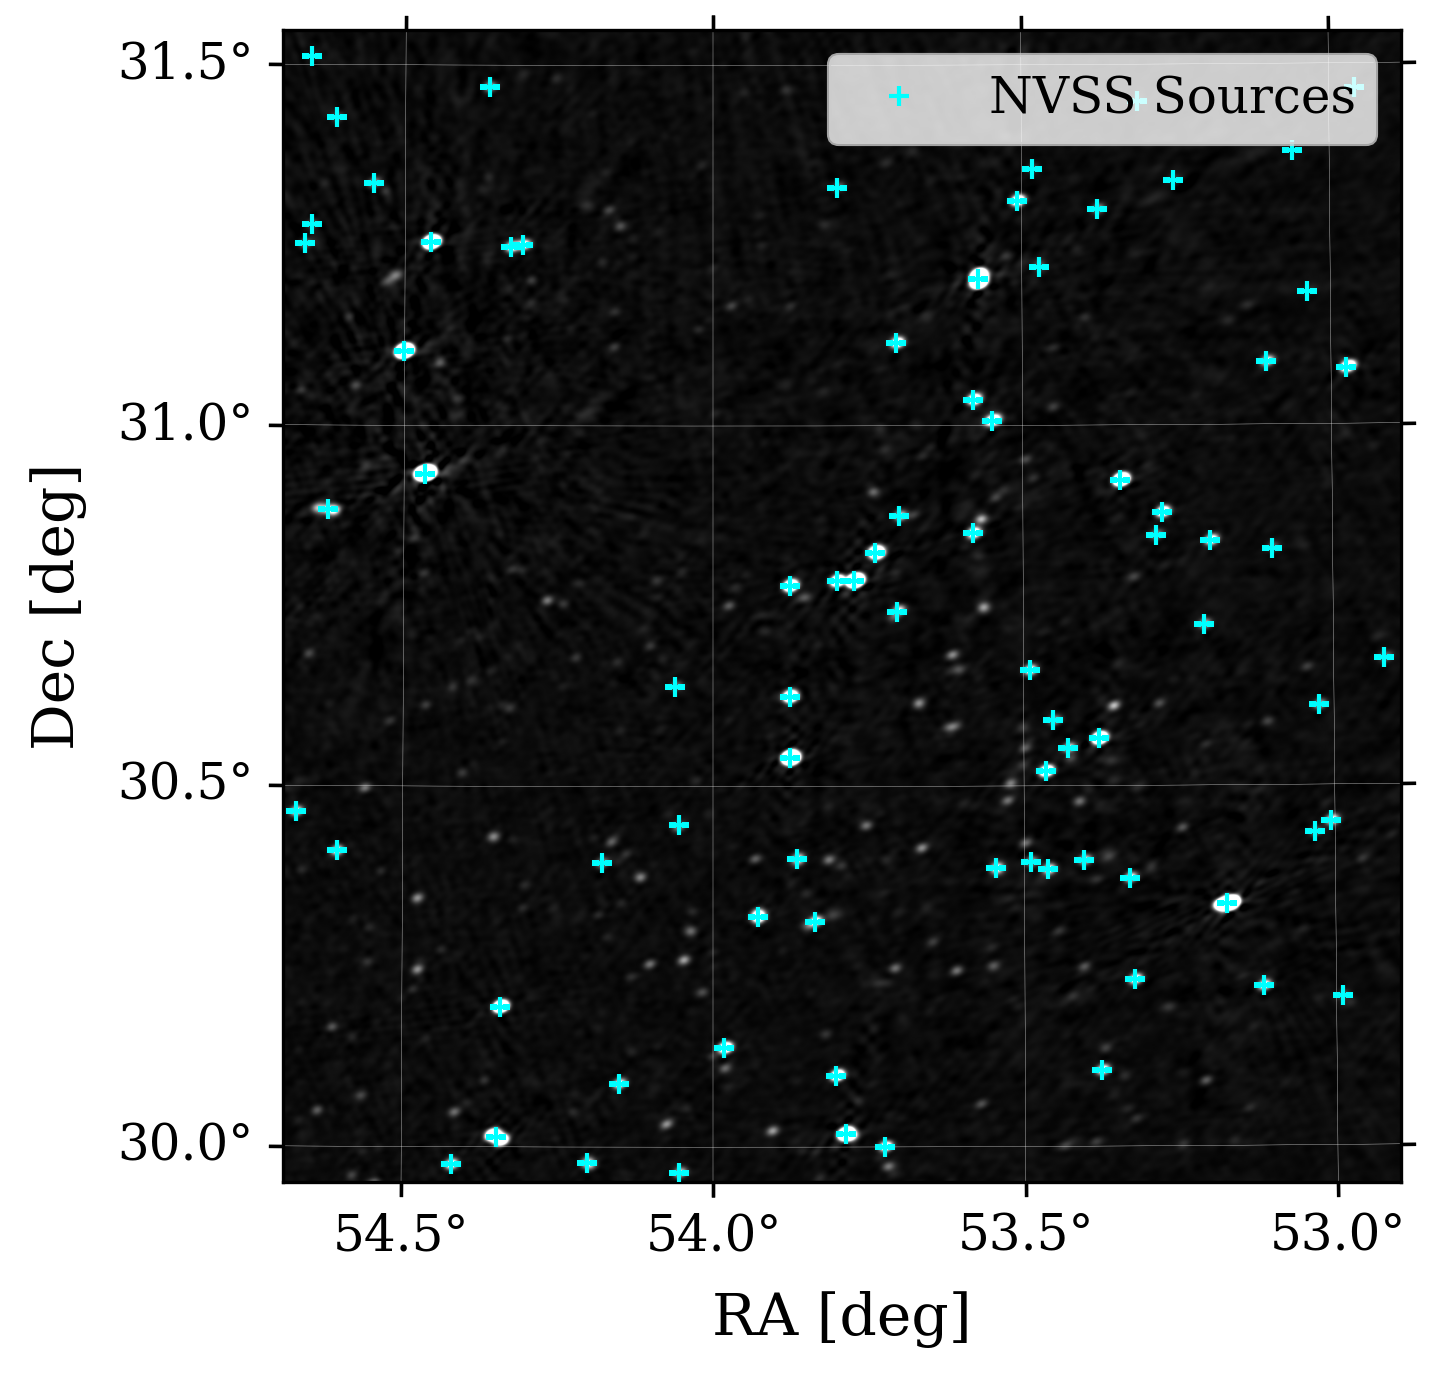

In [4]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle  # for clean decimal tick formatting
import astropy.units as u
import numpy as np
import pandas as pd

# === Inputs ===
vla_fits = '../server/total/36ALL.fits'
nvss_catalog = '../NVSS/C0336P32_I.pybdsf.srl'
center = SkyCoord('03h35m12s', '30d44m53s', frame='icrs')
box_width = 1.8 * u.deg
box_height = 1.6 * u.deg

# === Column names from header ===
col_names = ['Source_id', 'Isl_id', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Total_flux', 'E_Total_flux',
             'Peak_flux', 'E_Peak_flux', 'RA_max', 'E_RA_max', 'DEC_max', 'E_DEC_max', 'Maj', 'E_Maj',
             'Min', 'E_Min', 'PA', 'E_PA', 'Maj_img_plane', 'E_Maj_img_plane', 'Min_img_plane',
             'E_Min_img_plane', 'PA_img_plane', 'E_PA_img_plane', 'DC_Maj', 'E_DC_Maj', 'DC_Min',
             'E_DC_Min', 'DC_PA', 'E_DC_PA', 'DC_Maj_img_plane', 'E_DC_Maj_img_plane',
             'DC_Min_img_plane', 'E_DC_Min_img_plane', 'DC_PA_img_plane', 'E_DC_PA_img_plane',
             'Isl_Total_flux', 'E_Isl_Total_flux', 'Isl_rms', 'Isl_mean', 'Resid_Isl_rms',
             'Resid_Isl_mean', 'S_Code']

# === Load NVSS catalog ===
nvss_df = pd.read_csv(nvss_catalog, comment='#', delim_whitespace=True, names=col_names)
nvss_coords = SkyCoord(ra=nvss_df['RA'].values * u.deg,
                       dec=nvss_df['DEC'].values * u.deg,
                       frame='icrs')

# === Cutout Function ===
def cutout_preserving_wcs(fitsfile, center, width, height, output_file):
    hdul = fits.open(fitsfile)
    header = hdul[0].header
    data = hdul[0].data
    wcs_full = WCS(header)
    wcs_sky = wcs_full.celestial

    half_width = width.to(u.deg).value / 2
    half_height = height.to(u.deg).value / 2

    ra1, ra2 = center.ra.deg - half_width, center.ra.deg + half_width
    dec1, dec2 = center.dec.deg - half_height, center.dec.deg + half_height

    corner1 = SkyCoord(ra1, dec1, unit='deg')
    corner2 = SkyCoord(ra2, dec2, unit='deg')

    x1, y1 = wcs_sky.world_to_pixel(corner1)
    x2, y2 = wcs_sky.world_to_pixel(corner2)

    x1, x2 = int(np.floor(min(x1, x2))), int(np.ceil(max(x1, x2)))
    y1, y2 = int(np.floor(min(y1, y2))), int(np.ceil(max(y1, y2)))

    cut_data = data[..., y1:y2, x1:x2]

    new_header = header.copy()
    new_header['CRPIX1'] -= x1
    new_header['CRPIX2'] -= y1
    new_header['NAXIS1'] = x2 - x1
    new_header['NAXIS2'] = y2 - y1

    fits.writeto(output_file, cut_data, new_header, overwrite=True)
    return cut_data, WCS(new_header).celestial

# === Apply cutout to VLA map ===
vla_data, vla_wcs = cutout_preserving_wcs(
    vla_fits, center, box_width, box_height, '../paper1/figs/VLA_cutout.fits'
)

# === Filter NVSS sources inside the cutout area ===
half_width = box_width.to(u.deg).value / 2
half_height = box_height.to(u.deg).value / 2
in_box = (
    (np.abs(nvss_coords.ra.deg - center.ra.deg) < half_width) &
    (np.abs(nvss_coords.dec.deg - center.dec.deg) < half_height)
)
nvss_filtered = nvss_coords[in_box]

# === Plot VLA image with NVSS positions ===
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection=vla_wcs)

# Reduce data to 2D
if vla_data.ndim == 4:
    image = vla_data[0, 0]
elif vla_data.ndim == 3:
    image = vla_data[0]
else:
    image = vla_data

# Set image display range
vmin, vmax = np.nanpercentile(image, [1, 99.6])
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

# Plot NVSS sources
x, y = vla_wcs.world_to_pixel(nvss_filtered)
ax.plot(x, y, marker='+', linestyle='none', color='cyan', markersize=5, label='NVSS Sources')

# Set axis labels and format in degrees
# ax.set_title('VLA Data with NVSS Sources')
ax.coords.grid(True, color='white', ls='solid', linewidth=0.08)
ax.coords[0].set_axislabel('RA [deg]')
ax.coords[1].set_axislabel('Dec [deg]')
ax.coords[0].set_format_unit(u.deg)
ax.coords[1].set_format_unit(u.deg)
ax.coords[0].set_major_formatter('d.d')  # Decimal RA
ax.coords[1].set_major_formatter('d.d')  # Decimal Dec
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("../paper1/figs/VLA_with_NVSS_overlay.pdf", dpi=300, bbox_inches='tight')
# plt.show()
